# Project - Waste Classification

Waste is a significant global issue. Increasing volumes of waste are being generated as the global population and living standards rise. People are increasingly concerned about the production of waste and its effect, and are seeking ways to deal with the problem.

Recycling is the process of converting waste materials into new materials and objects. The recovery of energy from waste materials is often included in this concept. The recyclability of a material depends on its ability to reacquire the properties it had in its original state. It is an alternative to "conventional" waste disposal that can save material and help lower greenhouse gas emissions. Recycling can prevent the waste of potentially useful materials and reduce the consumption of fresh raw materials, thereby reducing: energy usage, air pollution (from incineration), and water pollution (from landfilling).

In this notebook, we will classify waste as organic or recyclable using Convolutional Neural Network (CNN).

## Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import cv2

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

for dirname, _, _ in os.walk(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset'):
        print(dirname)

C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Organic
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Recyclable
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Train
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Train\Organic
C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Train\Recyclable


## Convolutional Neural Network Approach

In [2]:
train_path = r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Train'
test_path = r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test'

## Data Visualization

In [3]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:20<00:00, 497.47it/s]


In [4]:
start =81
data['label'] = data['label'].str.slice(start)
data

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Organic
1,"[[[241, 242, 247], [241, 242, 247], [241, 242,...",Organic
2,"[[[224, 224, 224], [229, 229, 229], [236, 236,...",Organic
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Organic
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Organic
...,...,...
22559,"[[[212, 204, 202], [212, 204, 202], [212, 204,...",Recyclable
22560,"[[[205, 204, 202], [205, 204, 202], [205, 204,...",Recyclable
22561,"[[[136, 136, 144], [136, 136, 144], [137, 137,...",Recyclable
22562,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Recyclable


In [5]:
data.dtypes

image    object
label    object
dtype: object

In [6]:
data.shape

(22564, 2)

In [7]:
labels = list(data['label'])

In [8]:
from collections import Counter
Counter(labels)

Counter({'Organic': 12565, 'Recyclable': 9999})

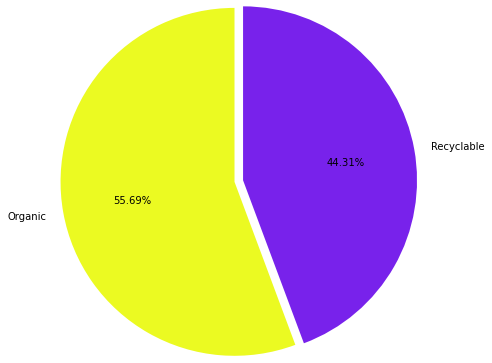

In [9]:
colors = ['#ebfa22','#7822eb']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

C:\Users\KIIT\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


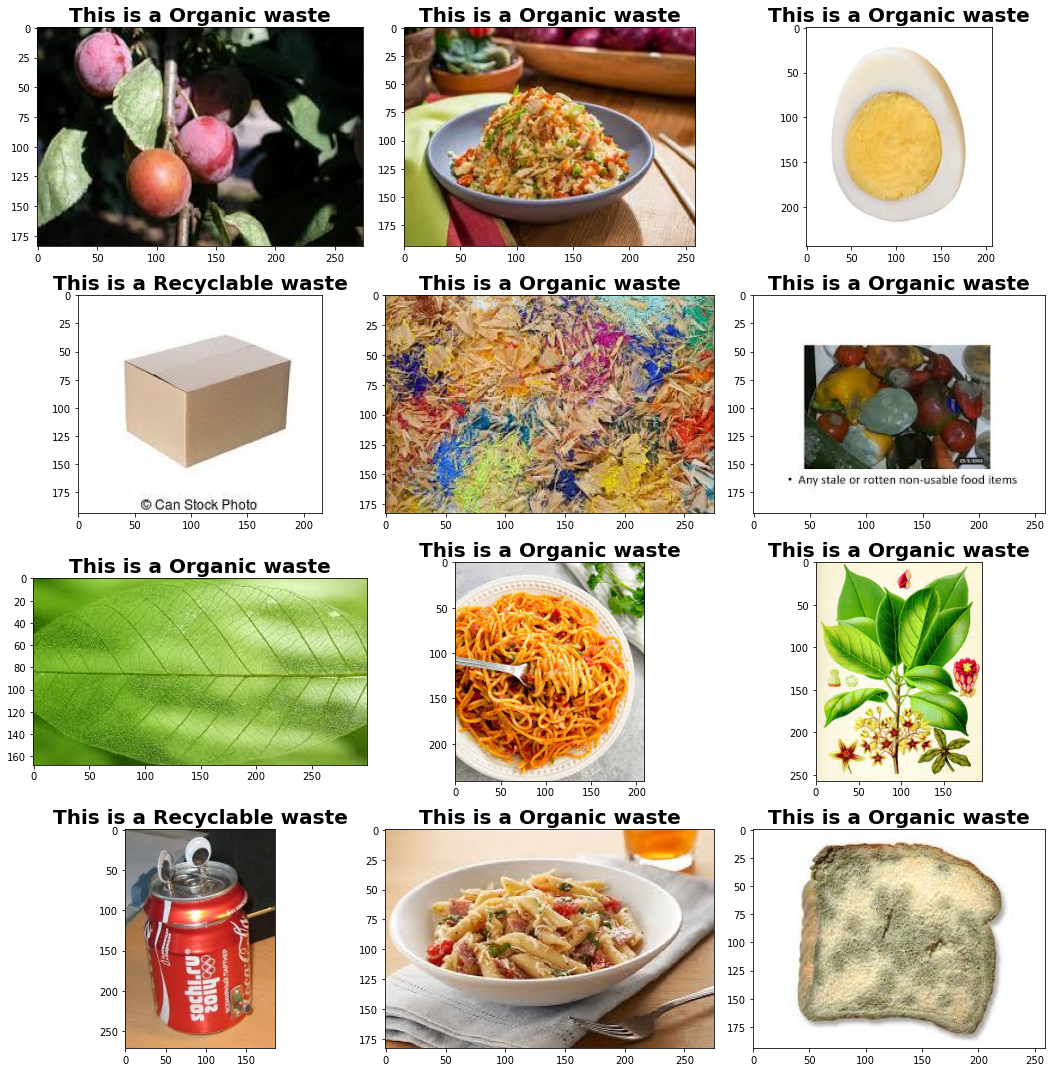

In [10]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This is a {0} waste'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [11]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


## Building the CNN Model

In [12]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

In [13]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [14]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [16]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=20,
        validation_data = test_generator)

C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
89/89 [==============================] - 975s 11s/step - loss: 0.7652 - accuracy: 0.6829 - val_loss: 0.3342 - val_accuracy: 0.8830
Epoch 2/20
89/89 [==============================] - 1027s 12s/step - loss: 0.4236 - accuracy: 0.8247 - val_loss: 0.3187 - val_accuracy: 0.8731
Epoch 3/20
89/89 [==============================] - 1015s 11s/step - loss: 0.4007 - accuracy: 0.8347 - val_loss: 0.3074 - val_accuracy: 0.8814
Epoch 4/20
89/89 [==============================] - 1139s 13s/step - loss: 0.3566 - accuracy: 0.8554 - val_loss: 0.3178 - val_accuracy: 0.8778
Epoch 5/20
89/89 [==============================] - 1185s 13s/step - loss: 0.3390 - accuracy: 0.8599 - val_loss: 0.2841 - val_accuracy: 0.8934
Epoch 6/20
89/89 [==============================] - 1049s 12s/step - loss: 0.3293 - accuracy: 0.8720 - val_loss: 0.2783 - val_accuracy: 0.8942
Epoch 7/20
89/89 [==============================] - 1126s 13s/step - loss: 0.2837 - accuracy: 0.8895 - val_loss: 0.2947 - val_accuracy: 0.8914


## MODEL EVALUATION

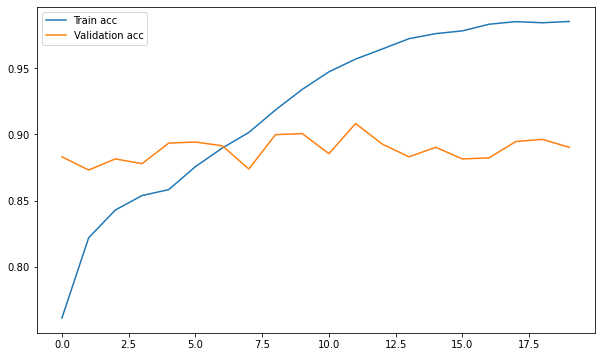

In [17]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

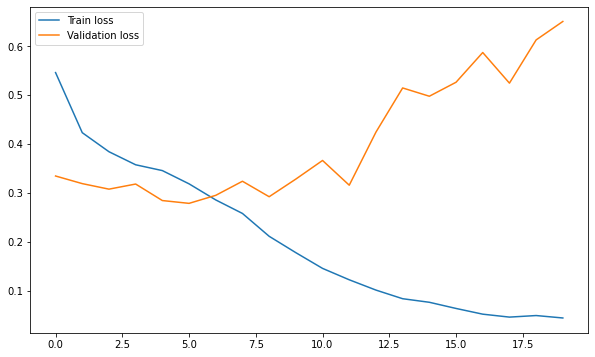

In [18]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [19]:
model.save(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Model/Waste_management CNN.model')

INFO:tensorflow:Assets written to: C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Model/Waste_management CNN.model\assets


## Applying the model on Test set 

In [2]:
from tensorflow.keras.models import load_model

In [3]:
model = load_model(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Model/Waste_management CNN.model')

In [4]:
test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [5]:
test_data = test_datagen.flow_from_directory(directory = r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 256)

Found 2513 images belonging to 2 classes.


### Test Cases:1 - ORGANIC

The image belongs to  Organic waste category


C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


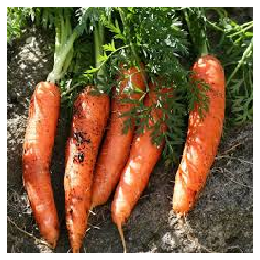

In [6]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Organic/O_12705.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to  Organic waste category


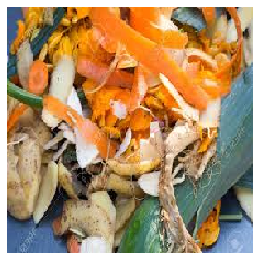

In [8]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Organic/O_13638.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to  Organic waste category


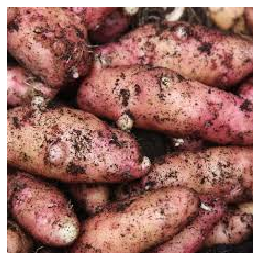

In [9]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Organic/O_13050.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to  Organic waste category


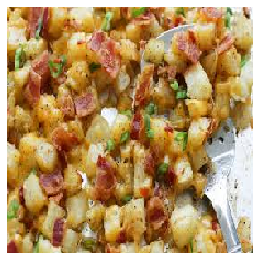

In [10]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Organic/O_13100.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

### Test Case:2 - RECYCLE

The image belongs to Recycle waste category 


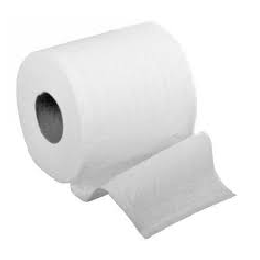

In [7]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Recyclable/R_10758.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to Recycle waste category 


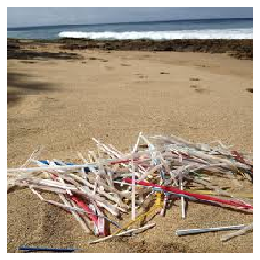

In [11]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Recyclable/R_10475.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to Recycle waste category 


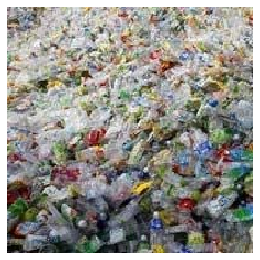

In [13]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Recyclable/R_10053.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")

The image belongs to Recycle waste category 


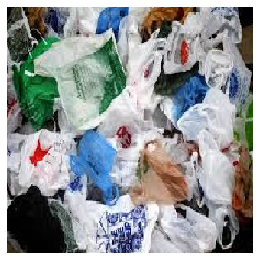

In [14]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Waste Classification\Dataset\Test\Recyclable/R_10434.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to  Organic waste category")
else:
    print("The image belongs to Recycle waste category ")